In [1]:
! rm -rf /kaggle/working/looped_transformer/

In [2]:
!git clone https://github.com/DMurawiecki/looped_transformer.git
!ls

Cloning into 'looped_transformer'...
remote: Enumerating objects: 447, done.
remote: Counting objects: 100% (311/311), done.
remote: Compressing objects: 100% (125/125), done.
remote: Total 447 (delta 239), reused 235 (delta 186), pack-reused 136
Receiving objects: 100% (447/447), 907.44 KiB | 19.31 MiB/s, done.
Resolving deltas: 100% (296/296), done.
__notebook__.ipynb  looped_transformer


In [3]:
!pip install funcy

In [4]:
!pip3 install -U zetascale

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.5/532.5 kB 17.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.4/872.4 kB 33.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.2/43.2 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 240.7/240.7 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.5/137.5 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 70.2 MB/s eta 0:00:00
  Attempting uninstall: rich
    Found existing installation: rich 13.7.0
    Uninstalling rich-13.7.0:
      Successfully uninstalled rich-13.7.0
  Attempting uninstall: accelerate
    Found existing installation: accelerate 0.32.1
    Uninstalling accelerate-0.32.1:
      Successfully uninstalled accelerate-0.32.1
ERROR: pip's dependency resolver does not 

In [5]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import copy
import matplotlib.pyplot as plt
import torch.nn.functional as F
import sys
from tqdm import tqdm
sys.path.append('/kaggle/working/looped_transformer/scripts')
from nano_gpt import GPT2Model, GPT2Config
from utils import eval_unlooped_model, aggregate_metrics, eval_looped_model
from models import TransformerModel, TransformerModelLooped

In [6]:
fig_hparam = {
    'figsize': (8, 5),
    'labelsize': 28,
    'ticksize': 20,
    'linewidth': 5,
    'fontsize': 15,
    'titlesize': 20,
    'markersize': 15
}

# font specification
fontdict = {'family': 'serif',
         'size': fig_hparam['fontsize'],
         }

In [7]:
def get_model(model, step, model_path= None):
    if step == -1:
        state_dict = torch.load(model_path, map_location='cpu')['model_state_dict']
    else:
        state_dict = torch.load(model_path, map_location='cpu')['model']

#     return state_dict
    unwanted_prefix = '_orig_mod.'
    for k,v in list(state_dict.items()):
        if k.startswith(unwanted_prefix):
            state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
    model.load_state_dict(state_dict, strict=True)

    return model


In [8]:
device = torch.device('cpu')

## Get dataset

In [9]:
class LinearRegression():
    def __init__(self, batch_size, n_points, n_dims, n_dims_truncated, device, w_star=None):
        super(LinearRegression, self).__init__()
        self.device = device
        self.xs = torch.randn(batch_size, n_points, n_dims).to(device)
        self.xs[..., n_dims_truncated:] = 0
        w_b = torch.randn(batch_size, n_dims, 1) if w_star is None else w_star.to(device)  # [B, d, 1]
        w_b[:, n_dims_truncated:] = 0
        self.w_b = w_b.to(device)
        self.ys = (self.xs @ self.w_b).sum(-1)  # [B, n]

sample_size = 1280
batch_size = 128
n_points = 41
n_dims_truncated = 20
n_dims = 4
real_task = LinearRegression(sample_size, n_points, n_dims, n_dims_truncated, device)
xs, ys, w_b = real_task.xs, real_task.ys, real_task.w_b

## load model with AB-layer and Benchmarks

In [10]:
result_errs = {}

In [11]:
paths = ['/kaggle/input/ab_evaluation/pytorch/default/1/state_loop_AB_4_dims_150k.pt',
         '/kaggle/input/ab_evaluation/pytorch/default/1/state_loop_requir_gr_4_dims_150k.pt',
        '/kaggle/input/ab_evaluation/pytorch/default/1/state_requir_gr_4_dims_150k_new.pt']
names = ['A-B Transformer', 'Looped Transformer', 'Universal Transformer']
n_positions = 101
n_embd = 256
n_head = 8
T = 500
n_layers = [2, 1]

for name, path, n_layer in tqdm(zip(names[:-1], paths[:-1], n_layers), total= len(names) - 1, desc='Processing models'):
    model = TransformerModelLooped(n_dims, n_positions, n_embd, n_layer, n_head)
    step = -1
    model = get_model(model, step, path)
    model = model.to(device)

    err, loop_err = eval_looped_model(model, xs, ys, loop_max=T)

    result_errs[name] = err
    
n_layer = 12
model = TransformerModel(n_dims, n_positions, n_embd, n_layer, n_head)
step = -1
model = get_model(model, step, paths[-1])
model = model.to(device)
err, loop_err = eval_unlooped_model(model, xs, ys)
result_errs[names[-1]] = err

Processing models:   0%|          | 0/2 [00:00<?, ?it/s]

number of parameters: 1.58M
0


Processing models:  50%|█████     | 1/2 [47:52<47:52, 2872.91s/it]

number of parameters: 0.79M
0


Processing models: 100%|██████████| 2/2 [1:04:51<00:00, 1945.58s/it]


number of parameters: 9.48M


### Also get the "weak" baseline

In [12]:
from utils import get_relevant_baselines

baselines = get_relevant_baselines("linear_regression")
# baseline_errs = {}
for baseline_model in baselines:
    y_pred = baseline_model(xs, ys)
    err = (y_pred.cpu() - ys.cpu()).square()
    result_errs[baseline_model.name] = err

In [13]:
result_errs_agg = aggregate_metrics(result_errs, n_dims_truncated)

In [14]:
# result_errs_agg

In [15]:
result_errs_agg.keys()

dict_keys(['A-B Transformer', 'Looped Transformer', 'Universal Transformer', 'Least Squares', '3-Nearest Neighbors', 'Averaging'])

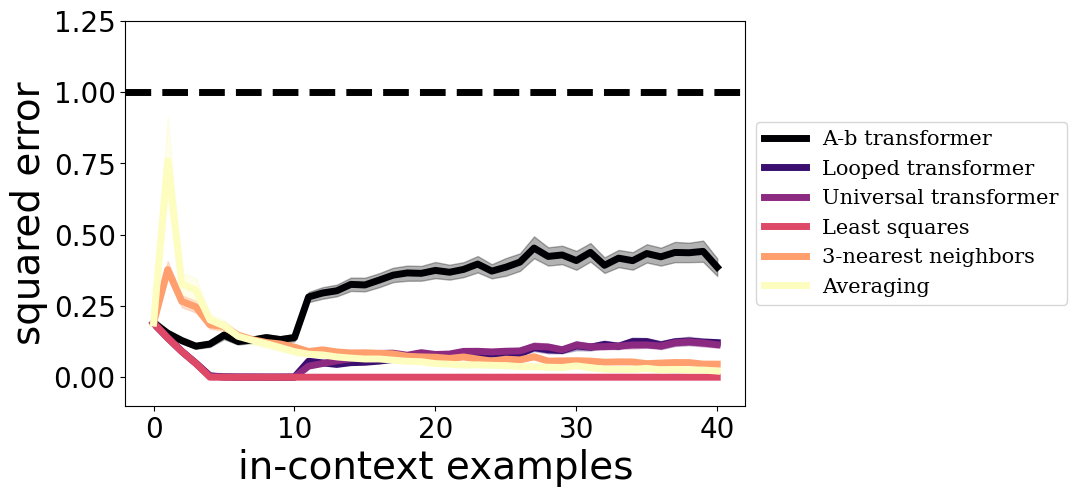

In [16]:
import matplotlib.pyplot as plt
import matplotlib

fig, ax = plt.subplots(1, figsize=fig_hparam['figsize'])

err_result_dict_agg = result_errs_agg

cmap = matplotlib.cm.get_cmap("magma")
result_name_list = ['A-B Transformer',
                    'Looped Transformer',
                    'Universal Transformer',
                    'Least Squares',
                    '3-Nearest Neighbors',
                    'Averaging']
colors = cmap(np.linspace(0, 1, len(result_name_list)))
for idx, model_name in enumerate(result_name_list):
    err = err_result_dict_agg[model_name]["mean"]
    ax.plot(err, color=colors[idx], lw=fig_hparam['linewidth'], label=model_name.capitalize())
    low = err_result_dict_agg[model_name]["bootstrap_low"]
    high = err_result_dict_agg[model_name]["bootstrap_high"]
    ax.fill_between(range(len(low)), low, high, alpha=0.3, color=colors[idx])

ax.tick_params(axis='both', labelsize=fig_hparam['ticksize'])
ax.axhline(1, color='k', ls='--', lw=fig_hparam['linewidth'])
ax.set_ylim(-0.1, 1.25)

plt.rc('font', family='serif')
ax.set_xlabel("in-context examples", fontsize=fig_hparam['labelsize'])
y_label = ax.set_ylabel("squared error", fontsize=fig_hparam['labelsize'])
legend = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=fig_hparam['fontsize'])
